In [1]:
from src.efficient_kan import KAN

/root/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

In [3]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [4]:
config = {}
config['input_dim'] = 1024*16
config['batch_size'] = 1024
config['hidden_layers'] = [4096, 2048]
config['lr'] = 1e-3

In [5]:
file_path = "data"
print(os.listdir(f'{file_path}/Data/genres_original/'))

['metal', 'disco', 'blues', 'hiphop', 'classical', 'country', 'jazz', 'pop', 'reggae', 'rock']


In [6]:
import librosa
import librosa.display

In [7]:
sound, sample_rate = librosa.load(f'{file_path}/Data/genres_original/classical/classical.00005.wav')

In [8]:
sound[:5], sample_rate, sound.shape

(array([-0.02459717, -0.04446411, -0.04428101, -0.05108643, -0.05322266],
       dtype=float32),
 22050,
 (661794,))

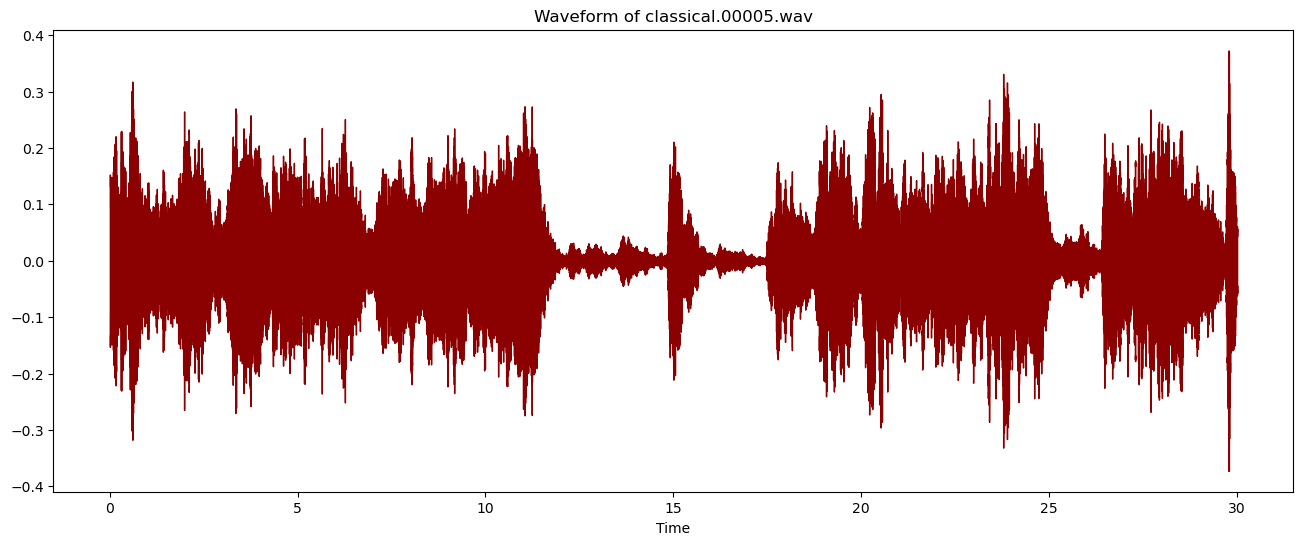

In [9]:
plt.figure(figsize=(16, 6))
librosa.display.waveshow(y=sound, sr=sample_rate, color="darkred")
plt.title("Waveform of classical.00005.wav", fontsize=12)  
plt.show()

In [10]:
class genres_dataset(Dataset):
    def __init__(self, root='data/Data/genres_original/', input_dim=1024, train=True):
        super(genres_dataset, self).__init__()
        self.classes = os.listdir(root)
        self.data = []
        self.train = train
        for _class in self.classes:
            wavs = os.listdir(os.path.join(root, _class))
            if train:
                sample_wav = wavs[:int(len(wavs)*0.7)]
            else:
                sample_wav = wavs[int(len(wavs)*0.7):]
            for wav in sample_wav:
                sound, sample_rate = librosa.load(os.path.join(root, _class, wav))
                for i in range(len(sound)//input_dim):
                    d={}
                    clip = sound[i*input_dim:(i+1)*input_dim]
                    d['clip'] = clip
                    d['class'] = _class
                    self.data.append(d)

    def __getitem__(self, index):
        data = self.data[index]
        _class = data['class']
        clip = data['clip']
        # sound, sample_rate = librosa.load(wav_path)
        target = torch.from_numpy(clip).squeeze().unsqueeze(0).to(torch.float32)
        return target, _class

    def __len__(self):
        return len(self.data)

trainset = genres_dataset(input_dim=config['input_dim'], train=True)
valset = genres_dataset(input_dim=config['input_dim'], train=False)
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=False)

In [11]:
trainset[0]

(tensor([[0.0407, 0.0460, 0.0314,  ..., 0.0842, 0.0566, 0.0339]]), 'metal')

In [12]:
class KAE(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        input_dim,
    ):
        super(KAE, self).__init__()
        self.encoder = KAN([input_dim, layers_hidden[0], layers_hidden[1]])
        self.decoder = KAN([layers_hidden[1], layers_hidden[0], input_dim])

    def forward(self, x: torch.Tensor):
        x = self.decoder(self.encoder(x))
        return x

In [13]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAE(layers_hidden=config['hidden_layers'], input_dim=config['input_dim'])
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.MSELoss()

In [14]:
import matplotlib.pyplot as plt

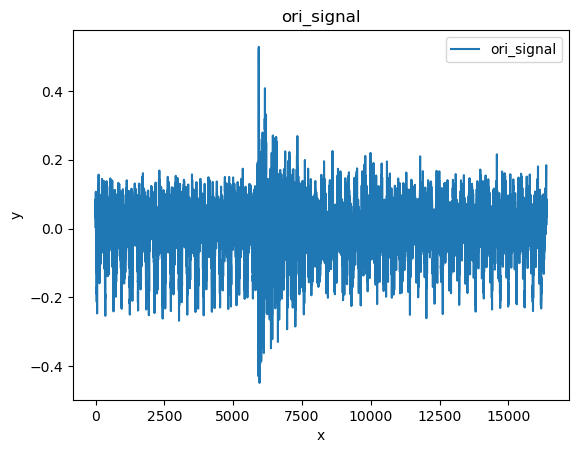

In [15]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, trainset[0][0][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('ori_signal')
plt.legend()
plt.savefig('assets/ori_signal.jpg')
plt.show()

In [16]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (targets, label) in enumerate(pbar):
            targets = targets.view(-1, config['input_dim']).to(device)
            optimizer.zero_grad()
            output = model(targets)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

    # # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (targets, label) in valloader:
            targets = targets.view(-1, config['input_dim']).to(device)
            output = model(targets)
            val_loss += criterion(output, targets).item()
            
    val_loss /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}"
    )
torch.save(model,'checkpoints/KAN_music_genres_pretrain.pth')

100%|██████████| 28/28 [00:04<00:00,  6.97it/s, loss=0.0231, lr=0.001]


Epoch 1, Val Loss: 0.02245170431810298


100%|██████████| 28/28 [00:03<00:00,  8.34it/s, loss=0.0208, lr=0.0008]


Epoch 2, Val Loss: 0.020533553673885763


100%|██████████| 28/28 [00:03<00:00,  7.95it/s, loss=0.0193, lr=0.00064]


Epoch 3, Val Loss: 0.019514237979560027


100%|██████████| 28/28 [00:03<00:00,  8.19it/s, loss=0.0183, lr=0.000512]


Epoch 4, Val Loss: 0.018994648059430932


100%|██████████| 28/28 [00:03<00:00,  8.00it/s, loss=0.0186, lr=0.00041]


Epoch 5, Val Loss: 0.018734963402883813


100%|██████████| 28/28 [00:03<00:00,  8.07it/s, loss=0.0194, lr=0.000328]


Epoch 6, Val Loss: 0.018599867130563195


100%|██████████| 28/28 [00:03<00:00,  8.35it/s, loss=0.0197, lr=0.000262]


Epoch 7, Val Loss: 0.018532688721149628


100%|██████████| 28/28 [00:03<00:00,  8.15it/s, loss=0.0192, lr=0.00021]


Epoch 8, Val Loss: 0.0184895945297155


100%|██████████| 28/28 [00:03<00:00,  8.28it/s, loss=0.0186, lr=0.000168]


Epoch 9, Val Loss: 0.01846215604538364


100%|██████████| 28/28 [00:03<00:00,  8.11it/s, loss=0.0203, lr=0.000134]


Epoch 10, Val Loss: 0.018442295092557157


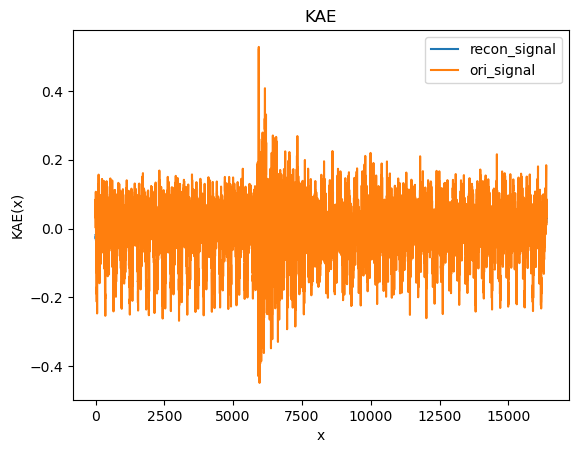

In [17]:
pred = model(trainset[0][0].to(device)).detach().cpu().numpy()[0]
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, pred, label='recon_signal')
plt.plot(x, trainset[0][0][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('KAE(x)')
plt.title('KAE')
plt.legend()
plt.savefig('assets/recon_signal.jpg')
plt.show()

In [18]:
mix_latent = model.encoder(trainset[0][0].to(device))/2 + model.encoder(trainset[1][0].to(device))/2
mixed_signal = model.decoder(mix_latent).detach().cpu().numpy()[0]
signal0 = model(trainset[0][0].to(device)).detach().cpu().numpy()[0]
signal1 = model(trainset[1][0].to(device)).detach().cpu().numpy()[0]

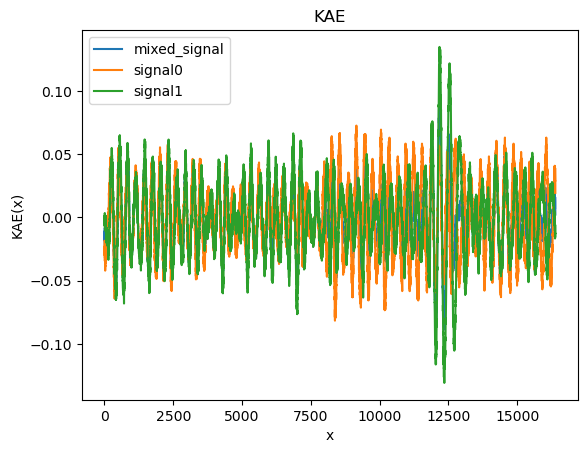

In [19]:
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, mixed_signal, label='mixed_signal')
plt.plot(x, signal0, label='signal0')
plt.plot(x, signal1, label='signal1')
plt.xlabel('x')
plt.ylabel('KAE(x)')
plt.title('KAE')
plt.legend()
plt.savefig('assets/mix_signal.jpg')
plt.show()